## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import random

import seaborn as sns #for visualisation
import matplotlib.pyplot as plt #for visualisation

import librosa #For audio processing
import librosa.display
from  IPython.display import Audio
import soundfile as sf

## Prepare dataset / Split Audiofiles

In [ ]:
raw_paths = [] #Audio file paths

#Reading the files
for dirname, _, filenames in os.walk('./dataset/raw'):
    for filename in filenames:
        raw_paths.append(os.path.join(dirname, filename))
        label = filename.split('-')[0]
    if len(raw_paths) == 2800:
        break
print('Dataset is Loaded')


# Parametres
output_dir = "./dataset/chunks"
chunk_duration = 3.0  # secondes
sample_rate = 16000

os.makedirs(output_dir, exist_ok=True)

#files datas:
paths = []
labels = []


def split_audio_into_chunks(raw_paths, offset_sec=0.0):
    paths = []
    labels = []
    global chunk_duration
    global sample_rate
    global output_dir

    for idx, path in enumerate(raw_paths):
        try:
            y, sr = librosa.load(path, sr=sample_rate, offset=offset_sec)
            total_duration = librosa.get_duration(y=y, sr=sr)
            samples_per_chunk = int(chunk_duration * sr)
            num_chunks = len(y) // samples_per_chunk

            for i in range(num_chunks):
                start = i * samples_per_chunk
                end = start + samples_per_chunk
                chunk = y[start:end]

                if len(chunk) < samples_per_chunk:
                    continue

                # File name
                base_filename = os.path.basename(path).replace('.wav', '')
                chunk_filename = f"{base_filename}_chunk_offset{int(offset_sec*1000)}ms_{i}.wav"
                chunk_path = os.path.join(output_dir, chunk_filename)

                # label (class) from the file name
                label = base_filename.split('-')[0].upper()

                paths.append(chunk_path)
                labels.append(label)
                sf.write(chunk_path, chunk, samplerate=sr)

        except Exception as e:
            print(f"Error on {path}: {e}")

    return paths, labels
r1, r2 = split_audio_into_chunks(raw_paths, 0)
paths.extend(r1)
labels.extend(r2)
r1, r2 = split_audio_into_chunks(raw_paths, 0.5)
paths.extend(r1)
labels.extend(r2)
r1, r2 = split_audio_into_chunks(raw_paths, 1)
paths.extend(r1)
labels.extend(r2)
r1, r2 = split_audio_into_chunks(raw_paths, 1.5)
paths.extend(r1)
labels.extend(r2)
r1, r2 = split_audio_into_chunks(raw_paths, 2)
paths.extend(r1)
labels.extend(r2)
r1, r2 = split_audio_into_chunks(raw_paths, 2.5)
paths.extend(r1)
labels.extend(r2)


print("Chunking finished ✅")


Dataset is Loaded


C:\Users\PC\AppData\Local\Temp\ipykernel_5960\2048329306.py:34: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sample_rate, offset=offset_sec)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Découpage terminé ✅


## Data Augmentation Functions

In [ ]:
# Adding white noise
def add_noise(path, output_dir, noise_factor=0.005):
    noise_factor = random.randint(1, 15) / 1000
    y, sr = librosa.load(path, sr=None)
    noise = np.random.randn(len(y))
    y_noisy = y + noise_factor * noise
    y_noisy = np.clip(y_noisy, -1.0, 1.0)

    base_name = os.path.basename(path).replace('.wav', f'_DAnoise.wav')
    output_path = os.path.join(output_dir, base_name)

    sf.write(output_path, y_noisy, sr)
    return output_path

# Pitch shifting
def pitch_shift(path, output_dir):
    y, sr = librosa.load(path, sr=None)
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.randint(0,2))

    # Build the path
    base_name = os.path.basename(path).replace('.wav', f'_DApitch{random.randint(0,100000)}.wav')
    output_path = os.path.join(output_dir, base_name)

    # writing the file
    sf.write(output_path, y_shifted, sr)

    return output_path

# Time stretching (fast or slower)
def time_stretch(path, output_dir, target_duration=3.0):
    # Choosing a random speed factor between 0.8 and 1.3
    rate = random.randint(800, 1300) / 1000

    # Loading the audio
    y, sr = librosa.load(path, sr=None)
    y_stretched = librosa.effects.time_stretch(y, rate=rate)

    target_length = int(sr * target_duration)

    # Adjust duration
    if len(y_stretched) > target_length:
        # We remove the end if the audio is too long (have been made slower)
        y_stretched = y_stretched[:target_length]
    elif len(y_stretched) < target_length:
        # We add white noise if the audio is to short (have been made faster)
        padding = target_length - len(y_stretched)
        noise = np.random.normal(0, 0.005, padding)
        y_stretched = np.concatenate([y_stretched, noise])

    # Building the output file name
    base_name = os.path.basename(path).replace('.wav', f'_DAstretch{rate:.3f}.wav')
    output_path = os.path.join(output_dir, base_name)

    # Saving
    sf.write(output_path, y_stretched, sr)
    return output_path

## Data Augmentation

(array([6001.,    0., 6001.,    0.,    0., 6001.,    0., 6001.,    0.,
        5996.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

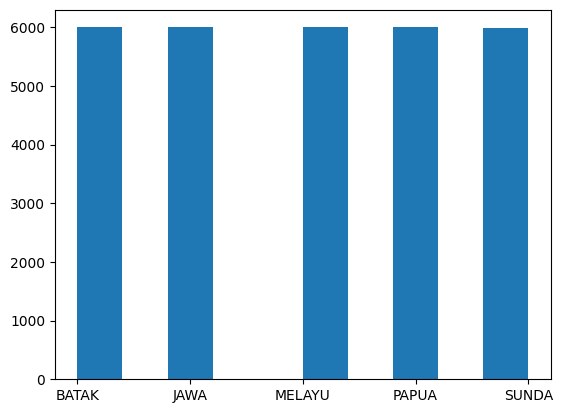

In [ ]:
chunks_by_class = 6000 #Number of audio wanted for each class
size = len(paths)
idx = 0

#While there is not enought audio file, we create one with DA.
while(len(paths) < chunks_by_class * len(set(labels))):
    #We will duplicate the audio at index idx
    if idx > size:
        idx = 0 #We just want to use the "clean" (non-already edited) audio, which are the first audios.
    if labels.count(labels[idx]) > chunks_by_class: 
        #If there is already too much audio on this class, we move onto the next.
        idx+=1
        continue
    i = random.randint(0,2)

    if i == 0:
        fileName = add_noise(paths[idx], './dataset/chunks/DA')
        paths.append(fileName)
        labels.append(labels[idx])
    elif i == 1:
        fileName = pitch_shift(paths[idx], './dataset/chunks/DA')
        paths.append(fileName)
        labels.append(labels[idx])
    else:
        fileName = time_stretch(paths[idx], './dataset/chunks/DA')
        paths.append(fileName)
        labels.append(labels[idx])
    idx+=1

plt.hist(labels)

In [5]:
np.save('paths', paths)
np.save('labels', labels)

## Feature extraction MFCC

In [ ]:
from tqdm import tqdm

def extract_mfcc_features(paths, n_mfcc=13, duration=3.0, sr=22050):
    features = []

    hop_length = int(0.01 * sr)  # 10 ms
    win_length = int(0.025 * sr) # 25 ms
    max_len = int(librosa.time_to_frames(duration, sr=sr, hop_length=hop_length))

    for path in tqdm(paths, desc="Extraction MFCC"):
        y, sr = librosa.load(path, sr=sr, duration=duration)

        # Pre-emphasis
        y = np.append(y[0], y[1:] - 0.97 * y[:-1])

        # Padding if the file is too short
        if len(y) < int(sr * duration):
            pad_len = int(sr * duration) - len(y)
            y = np.pad(y, (0, pad_len))

        # MFCC extraction
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=n_mfcc,
            hop_length=hop_length,
            win_length=win_length,
            window='hamming',
            lifter=22
        )

        # Normalisation
        mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / (np.std(mfcc, axis=1, keepdims=True) + 1e-6)

        # Pad/crop for constant size
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        features.append(mfcc)

    return np.array(features)

In [8]:
X = extract_mfcc_features(paths, 13)
y = labels

#Saving the data
np.save('mfcc_features.npy', X)
np.save('mfcc_labels.npy', y)
print("✅ MFCCs and labels saved.")

Extraction MFCC: 100%|██████████| 30000/30000 [10:23<00:00, 48.15it/s]


✅ MFCCs and labels saved.
